<a href="https://colab.research.google.com/github/msfalif404/senam-kaggle/blob/main/Kaggle_Playground_S5E1_Forecasting_Sticker_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Playground - S5E1 - Forecasting Sticker Sales

## Importing Library

In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install category_encoders
!pip install scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.1
    Uninstalling scikit-learn-1.3.1:
      Successfully uninstalled scikit-learn-1.3.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.8.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.3.1 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scik

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# import category_encoders as ce

## Reading The Dataset

In [ ]:
df = pd.read_csv('train.csv')

train_df = df.copy()
train_df = train_df.sort_values(by='date')

test_df = pd.read_csv('test.csv')
test_df = test_df.sort_values(by='date')

## Data Overview

In [ ]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
65,65,2010-01-01,Norway,Stickers for Less,Holographic Goose,579.0
64,64,2010-01-01,Norway,Discount Stickers,Kerneler Dark Mode,911.0
63,63,2010-01-01,Norway,Discount Stickers,Kerneler,791.0
62,62,2010-01-01,Norway,Discount Stickers,Kaggle Tiers,1525.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 12.3+ MB


In [ ]:
train_df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,8871


In [ ]:
test_df.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
65,230195,2017-01-01,Norway,Stickers for Less,Holographic Goose
64,230194,2017-01-01,Norway,Discount Stickers,Kerneler Dark Mode
63,230193,2017-01-01,Norway,Discount Stickers,Kerneler
62,230192,2017-01-01,Norway,Discount Stickers,Kaggle Tiers


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.5+ MB


In [ ]:
test_df.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0


In [ ]:
train_df['country'].value_counts()

,count
country,
Canada,38355
Norway,38355
Kenya,38355
Singapore,38355
Italy,38355
Finland,38355


In [ ]:
train_df['store'].value_counts()

,count
store,
Discount Stickers,76710
Stickers for Less,76710
Premium Sticker Mart,76710


## Missing Value Heatmap

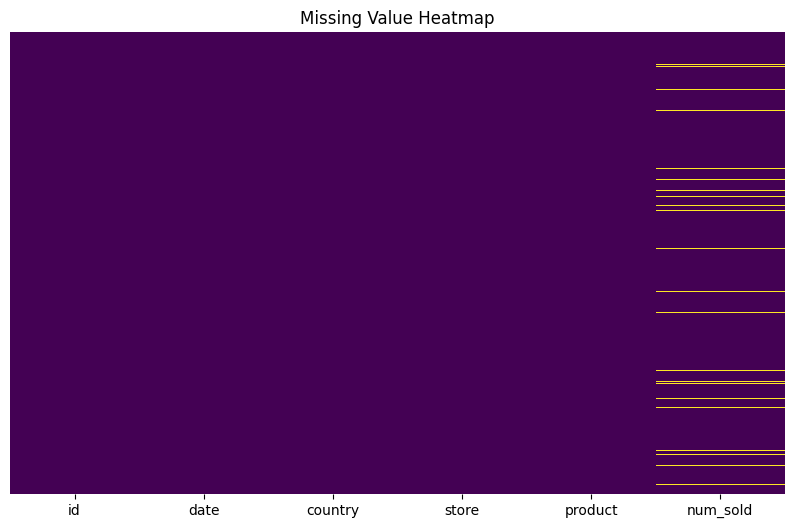

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Value Heatmap")
plt.show()

## Outlier

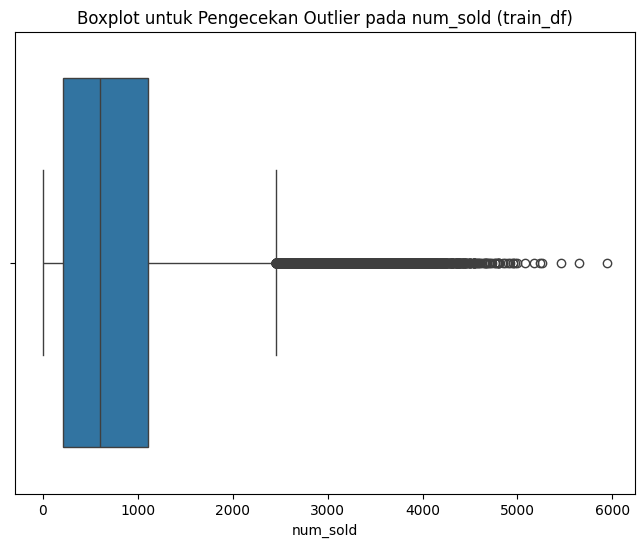

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df["num_sold"])
plt.title("Boxplot untuk Pengecekan Outlier pada num_sold (train_df)")
plt.show()

## Data Pre-processing

### Capping Nilai Outlier

In [ ]:
# Q1 = df["num_sold"].quantile(0.25)
# Q3 = df["num_sold"].quantile(0.75)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR

# df["num_sold"] = df["num_sold"].apply(lambda x: min(x, upper_bound) if pd.notnull(x) else x)

# plt.figure(figsize=(8, 6))
# sns.boxplot(x=df["num_sold"])
# plt.title("Boxplot untuk Pengecekan Outlier pada num_sold")
# plt.show()

## Date Extraction

In [ ]:
train_df["date"] = pd.to_datetime(train_df["date"])
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
train_df["is_weekend"] = train_df["date"].dt.weekday.isin([5, 6])
train_df["quarter"] = train_df["date"].dt.quarter

test_df["date"] = pd.to_datetime(test_df["date"])
test_df["year"] = test_df["date"].dt.year
test_df["month"] = test_df["date"].dt.month
test_df["day"] = test_df["date"].dt.day
test_df["is_weekend"] = test_df["date"].dt.weekday.isin([5, 6])
test_df["quarter"] = test_df["date"].dt.quarter

def add_cyclical_features(df):
    # Maksimum nilai periode
    max_day = 31
    max_month = 12
    max_year = df["year"].max() - df["year"].min() + 1  # Rentang tahun dalam dataset

    # Transformasi sin dan cos untuk periodik
    df["day_sin"] = np.sin(2 * np.pi * df["day"] / max_day)
    df["day_cos"] = np.cos(2 * np.pi * df["day"] / max_day)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / max_month)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / max_month)

    df["year_sin"] = np.sin(2 * np.pi * (df["year"] - df["year"].min()) / max_year)
    df["year_cos"] = np.cos(2 * np.pi * (df["year"] - df["year"].min()) / max_year)

    return df

train_df = add_cyclical_features(train_df)
test_df = add_cyclical_features(test_df)

## Explanatory Data Analysis

### Distribusi Negara

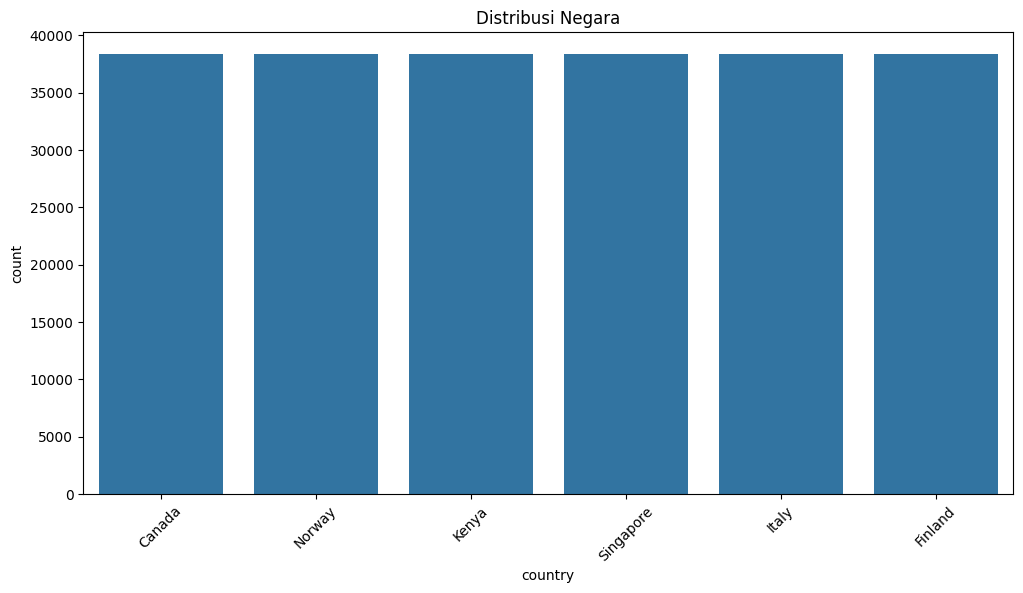

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='country', data=train_df, order=train_df['country'].value_counts().index)
plt.title('Distribusi Negara')
plt.xticks(rotation=45)
plt.show()

### Distribusi Store

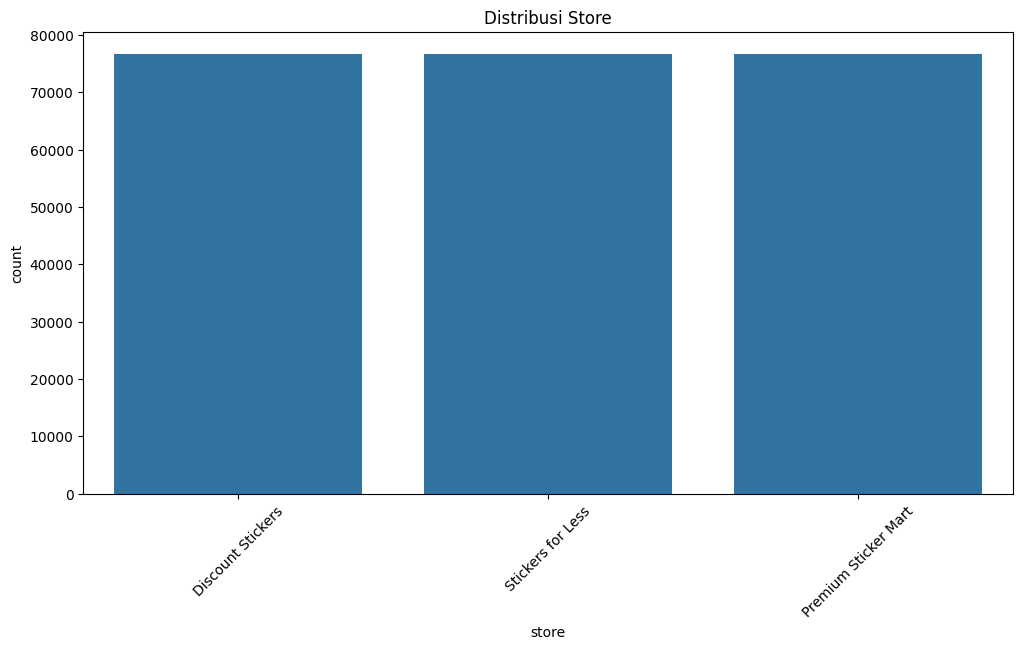

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='store', data=train_df, order=train_df['store'].value_counts().index)
plt.title('Distribusi Store')
plt.xticks(rotation=45)
plt.show()

### Distribusi Negara Terhadap Penjualan

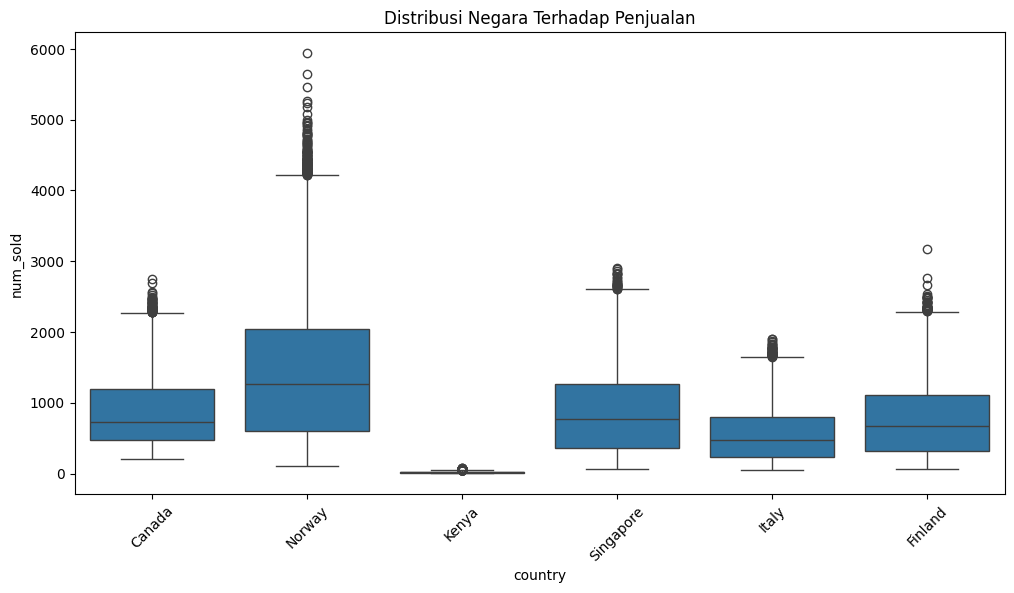

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='num_sold', data=train_df)
plt.title('Distribusi Negara Terhadap Penjualan')
plt.xticks(rotation=45)
plt.show()

### Distribusi Store Terhadap Penjualan

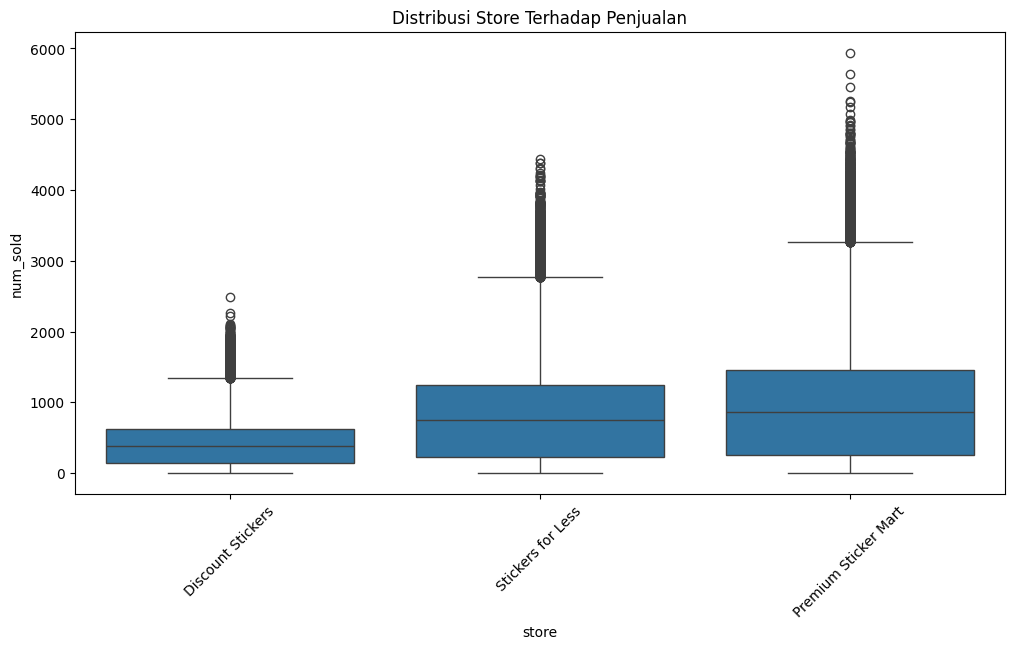

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='store', y='num_sold', data=train_df)
plt.title('Distribusi Store Terhadap Penjualan')
plt.xticks(rotation=45)
plt.show()

### Distribusi Penjualan Negara Terhadap num_sold

In [ ]:
# # Visualisasi line chart untuk setiap negara terhadap num_sold
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=df, x="date", y="num_sold", hue="country")
# plt.title("Tren Penjualan per Negara")
# plt.xlabel("Tanggal")
# plt.ylabel("Jumlah Terjual")
# plt.xticks(rotation=45)
# plt.legend(title="Negara")
# plt.show()

### Distribusi Penjualan Store Terhadap num_sold

In [ ]:
# # Visualisasi line chart untuk setiap Store terhadap num_sold
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=df, x="date", y="num_sold", hue="store")
# plt.title("Tren Penjualan per Store")
# plt.xlabel("Tanggal")
# plt.ylabel("Jumlah Terjual")
# plt.xticks(rotation=45)
# plt.legend(title="Store")
# plt.show()

## Removing Irrelevant Features

In [ ]:
train_df = train_df.drop(columns=['id','date'])
test_df = test_df.drop(columns=['date'])

## Encoding Categorical Variable

In [ ]:
# train_df['store'] = train_df['store'].map({'Discount Stickers': 1, 'Stickers for Less': 2, 'Premium Sticker Mart': 3})
# test_df['store'] = test_df['store'].map({'Discount Stickers': 1, 'Stickers for Less': 2, 'Premium Sticker Mart': 3})

In [ ]:
train_df.dropna(inplace=True)

## Time Series Cross Validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
X = train_df.drop(columns=['num_sold'])
y = train_df['num_sold']

X_encoded = pd.get_dummies(X, columns=['store', 'product', 'country'], drop_first=True)

## Creating and Training Machine Learning Model

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    objective='reg:squarederror',
    missing=np.nan,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
)

catboost_model = CatBoostRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    loss_function='MAPE',
    od_type='Iter',
    subsample=0.8,
    reg_lambda=1.5,
    random_seed=42,
    bootstrap_type='Bernoulli',
    verbose=False
)

lgb_model = LGBMRegressor(
    n_estimators=1000,
    max_depth=13,
    learning_rate=0.05,
    objective='mape',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    boosting_type='gbdt',
)

models = {
    'XGBoost': xgb_model,
    'CatBoost': catboost_model,
    'LightGBM': lgb_model
}

In [ ]:
# categorical_cols = ["country", "store", "product"]
# target_encoder = ce.TargetEncoder(cols=categorical_cols)

# # for model_name, model in models.items():
# #     print(f"\nTraining {model_name} Model")

# #     for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
# #         X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
# #         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# #         # Fit Target Encoder hanya di data training, lalu transform ke training & testing
# #         target_encoder.fit(X_train[categorical_cols], y_train)
# #         X_train[categorical_cols] = target_encoder.fit_transform(X_train[categorical_cols], y_train)
# #         X_test[categorical_cols] = target_encoder.transform(X_test[categorical_cols])

# #         # Train model
# #         model.fit(X_train, y_train)

# #         # Predict
# #         y_pred = model.predict(X_test)

# #         # Evaluate RMSE
# #         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# #         print(f'RMSE for fold {fold}: {rmse:.4f}')

## Hyperparameter Tuning

In [ ]:
!pip install optuna

In [ ]:
# import optuna

# cv_split = TimeSeriesSplit(n_splits=5)

# def objective(trial):
#     params = {
#         'n_estimators': 1000,
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'max_depth': trial.suggest_int('max_depth', 13, 20),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'objective': 'reg:squarederror',
#         'random_state': 42,
#     }

#     model = XGBRegressor(**params)
#     rmse_scores = []

#     for train_index, test_index in cv_split.split(X):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         target_encoder.fit(X_train[categorical_cols], y_train)
#         X_train[categorical_cols] = target_encoder.fit_transform(X_train[categorical_cols], y_train)
#         X_test[categorical_cols] = target_encoder.transform(X_test[categorical_cols])

#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)

#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)

# # Create a study object
# study = optuna.create_study(direction='minimize')
# # Run the optimization
# study.optimize(objective, n_trials=3)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

In [ ]:
best_params = {
    'learning_rate': 0.20254427969267008,
    'max_depth': 13,
    'subsample': 0.9979149479174674,
    'colsample_bytree': 0.6510169540350895,
    'reg_alpha': 6.930152096776428,
    'reg_lambda': 8.568296096463422
}

final_model = XGBRegressor(**best_params)

In [ ]:
best_params

{'learning_rate': 0.20254427969267008,
 'max_depth': 13,
 'subsample': 0.9979149479174674,
 'colsample_bytree': 0.6510169540350895,
 'reg_alpha': 6.930152096776428,
 'reg_lambda': 8.568296096463422}

In [ ]:
final_model.fit(X_encoded, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6510169540350895, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.20254427969267008, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
X_test_df = test_df.drop(columns=['id'])
X_test_df_encoded = pd.get_dummies(X_test_df, columns=['store', 'product', 'country'], drop_first=True)

y_pred = final_model.predict(X_test_df_encoded)

In [ ]:
pred_results = pd.DataFrame({
    'id': test_df['id'],
    'num_sold': y_pred
})

In [ ]:
pred_results.to_csv('last_submission.csv', index=False)

## Predict